# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Nesse modelo vamos passar a considerar os textos das íntegras.

A primeira passagem, serão criadas colunas com as palavras-chaves informadas pela área negocial que vão indicar a ausência ou presença do termo no texto da íntegra da peça de promoção do arquivamento.

Na segunda passagem, vamos passar a considerar unicamente o texto da íntegra.

**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados.

Vamos ler os textos das íntegras, limpá-los e associar ao dataframe com os dados de homologação.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"

In [4]:
# carga dos textos

from os import listdir
from os.path import isfile, join
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('portuguese')
stop_words.extend(['n', 'nº', 'n°', 'n.º', ',', '.', '!', '?', ';', ':', '...', 'º', '–', '/', '(', ')'])

def get_text(file):
    with open(file, encoding='utf-8', errors='replace') as f:
        data=' '.join(line.strip() for line in f)
        f.close()
    
    return data.strip()

def get_text_non_stop_words(text):
    filtered_text = ''
    for w in word_tokenize(text, language='portuguese'):
        if w not in stop_words:
            filtered_text += w
            filtered_text += ' '            
    return filtered_text.strip()   
    

folder_integras = f'{PATH}/integras-textos'

texts = {}
for file in listdir(folder_integras):
    if isfile(join(folder_integras, file)):
        texts[file.split('.')[0]] = get_text(join(folder_integras,file))
    else:
        print('is not file', file)



In [7]:
# montando um DataFrame
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')
df_work = df_original.copy()
cols = ['id', 'homologado']
df_work.drop(inplace=True, columns=[col for col in df_work.columns if col not in cols])
df_work['peca_promocao'] = None
df_work.sample(5)

,homologado,id,peca_promocao
4802,1,72587721,None
3990,1,78396355,None
1962,1,81659665,None
3822,1,63162953,None
848,1,82676712,None


In [8]:
# Associando o texto...
for key, text in zip(texts.keys(), texts.values()):
    if key != '' and text != '':
        df_work.loc[df_work.id == int(key), 'peca_promocao'] = text
        
df_work.sample(5)

,homologado,id,peca_promocao
977,1,74458116,MINISTÉRIO PÚBLICO FEDERAL Procuradoria da Rep...
3394,1,79486305,Ref: Procedimento Preparatório nº 1.26.000.002...
7884,1,59492811,EMPRESA BRASILEIRA DE CORREIOS E TELÉGRAFOS – ...
4825,1,73891027,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...
7811,1,59664529,None


In [9]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

7792 125


In [10]:
# removendo os sem textos de peça de promoção (problema nos dados)
print(len(df_work[df_work['peca_promocao'].isnull()]))
df_work.dropna(subset=['peca_promocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)
print(len(df_work[df_work['peca_promocao'].isnull()]))

1636
0


In [11]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

6186 95


In [12]:
#Carga das palavras chaves
palavras_chaves = pd.read_csv(f'{PATH}/1A.CAM.palavras-chaves.txt')
palavras_chaves

,palavras-chaves,expressao-regular
0,AUSÊNCIA DE IRREGULARIDADES,\bausência[s]?\b(\s)+\bde\b(\s)+\birregularida...
1,IRREGULARIDADE SANADA,\birregularidade[s]?\b(\s)+\bsanada[s]?\b
2,NÃO COMPROVAÇÃO,\bnão\b(\s)+\bcomprovação\b
3,INEXISTÊNCIA,\binexistência[s]?\b
4,SOLUCIONADA,\bsolucionada[s]?\b
5,EXAURIMENTO,\bexaurimento\b
6,EXAURIDA,\bexaurida[s]?\b
7,PERDA DE OBJETO,\bperda\b(\s)+\bde\b(\s)+\bobjeto\b
8,IRREGULARIDADE NÃO COMPROVADA,\birregularidade[s]?\b(\s)+\bnão\b(\s)+\bcompr...
9,INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE,\binexistência\b(\s)+\bde\b(\s)+\bindício[s]?\...


## Busca de palavras-chaves nos textos das peças de promoção

Dada a lista de palavras-chaves anteriormente listada, vamos procurá-la nos textos das íntegras.

Vamos criar uma coluna para cada uma das palavras-chaves e marcar com ausência ou presença da mesma no texto correspondente.

Vamos utilzar expressões regulares.

In [13]:
pcs = palavras_chaves['palavras-chaves']

# vou ignorar as colunas com o caractere '+' // PRECISAMOS TRATAR ISSO AINDA
for pc in pcs:
    if pc.rfind('+') == -1:
        df_work[pc.strip()] = 0

df_work.sample(5)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
5092,1,71619108,EXMA MINISTÉRIO PÚBLICO FEDERAL f. / PRM-...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1901,1,40435204,PRM-SRC-SP-________/_____ MINISTÉRIO PÚBLICO ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
989,1,79699034,PR-AP-00020747/2018 MINISTÉRIO PÚBLICO FEDERA...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,1,80477354,PR-SC-00029337/2018 6º OFÍCIO NÚCLEO DE...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3040,1,78009524,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA 1...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
import re

for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        regex = re.compile(palavras_chaves['expressao-regular'][i], re.IGNORECASE)
        column = palavras_chaves['palavras-chaves'][i]
        for key in range(len(df_work)):
            if re.search(regex, df_work['peca_promocao'][key]):
                df_work.loc[key, column] = 1
            
df_work.sample(10)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
4837,1,74141415,Ofício nº 001/01-GAB/PRE/CE PR-CE-00043240/2...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2710,1,83270986,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5058,0,40062938,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,1,78917563,PRM-JAU-SP-00003119/2018 MINISTÉRIO PÚBLICO F...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4637,1,73811180,MANDADO DE SEGURANÇA Nº 2001 MINISTÉRIO PÚBL...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3354,1,70187530,EXMO 3º Of cio da Tutela Coletivaí Inquérit...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2304,1,77102665,Procedimento Preparatório nº 1.25.000.000935/2...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269,1,65079532,PROMOÇÃO DE ARQUIVAMENTO IC 1.36.001.000150/2...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,1,79753020,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3841,1,68843162,ENCAMINHAMENTO DE PROCESSOS DO FUNDEF À PRR 5A...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlacionando as palavras-chaves com a homologação/não homologação

A ideia aqui é mostrar o percentual de presença/ausência de palavras chaves e suas relações com a variável dependente.

In [15]:
df_homologado = df_work[df_work['homologado'] == 1]
df_nao_homologado = df_work[df_work['homologado'] == 0]
len(df_homologado), len(df_nao_homologado)

(6186, 95)

In [16]:
# verificando a quantidade nos homologados
p_homologados = {}
for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        column = str(palavras_chaves['palavras-chaves'][i])
        len_column = len(df_homologado[df_homologado[column] == 1])
        p_homologados[column] = len_column


print(sorted(p_homologados.items(), key=lambda kv: kv[1]))

[('INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES', 0), ('RECOMENDAÇÃO EXPEDIDA E ACATADA', 0), ('JUSTIFICATIVAS SATISFATÓRIAS', 1), ('IRREGULARIDADE NÃO CONFIRMADA', 3), ('INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE', 4), ('IRREGULARIDADE NÃO COMPROVADA', 7), ('RECOMENDAÇÃO ATENDIDA', 7), ('RECOMENDAÇÃO ACATADA', 10), ('CORREÇÃO DAS FALHAS', 14), ('QUESTÃO JUDICIALIZADA', 19), ('MAMOGRAFIA', 26), ('NÃO COMPROVAÇÃO', 31), ('SISCAN', 33), ('AÇÃO AJUIZADA', 35), ('PERDA DE OBJETO', 41), ('IRREGULARIDADE SANADA', 42), ('EXAURIMENTO', 81), ('EXAURIDA', 87), ('SOLUCIONADA', 152), ('EXCESSO DE PESO', 158), ('CUMPRIDAS', 301), ('DIREITO INDIVIDUAL', 320), ('AUSÊNCIA DE IRREGULARIDADES', 391), ('INEXISTÊNCIA', 1049), ('ADOTADAS', 1545)]


In [18]:
# verificando a quantidade nos não homologados
p_nao_homologados = {}
for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        column = str(palavras_chaves['palavras-chaves'][i])
        len_column = len(df_nao_homologado[df_nao_homologado[column] == 1])
        p_nao_homologados[column] = len_column


print(sorted(p_nao_homologados.items(), key=lambda kv: kv[1]))

[('IRREGULARIDADE SANADA', 0), ('IRREGULARIDADE NÃO COMPROVADA', 0), ('INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE', 0), ('IRREGULARIDADE NÃO CONFIRMADA', 0), ('RECOMENDAÇÃO ATENDIDA', 0), ('RECOMENDAÇÃO ACATADA', 0), ('INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES', 0), ('RECOMENDAÇÃO EXPEDIDA E ACATADA', 0), ('JUSTIFICATIVAS SATISFATÓRIAS', 0), ('AÇÃO AJUIZADA', 0), ('QUESTÃO JUDICIALIZADA', 0), ('EXCESSO DE PESO', 0), ('MAMOGRAFIA', 0), ('SISCAN', 0), ('EXAURIMENTO', 1), ('EXAURIDA', 1), ('PERDA DE OBJETO', 1), ('CORREÇÃO DAS FALHAS', 1), ('NÃO COMPROVAÇÃO', 2), ('DIREITO INDIVIDUAL', 2), ('SOLUCIONADA', 4), ('CUMPRIDAS', 4), ('AUSÊNCIA DE IRREGULARIDADES', 5), ('INEXISTÊNCIA', 18), ('ADOTADAS', 26)]


**IMPORTANTE**

Verificar os casos acima, de não homologados, em que há as palavras-chaves listadas:

- Perda de Objeto (*nesse caso, o procedimento foi enviado erroneamente para a 1A.CAM - era da 7A.CAM*)
- Correção de Falhas
- Não comprovação
- Direito Individual
- Ausência de Irregularidades (1.23.000.001516/2017-78)

In [29]:
df_nao_homologado[df_nao_homologado['AUSÊNCIA DE IRREGULARIDADES'] == 1]

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
1035,0,78276237,IC nº 1.23.000.001516/2017-78 DESPACHO DE...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1227,0,53757662,PROMOÇÃO DE ARQUIVAMENTO Inquérito Civil n...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1763,0,76856288,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2403,0,81744837,MINISTÉRIO PÚBLICO FEDERAL Procuradoria da Rep...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2656,0,81084991,Promoção de Arquivamento Procedimento Prepar...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import matplotlib.pyplot as plt

def plot_keywords(p):
    names = list(p.keys())
    values = list(p.values())
    plt.bar(range(len(p)), values, tick_label = names)
    plt.xticks(range(len(p)), names, rotation='vertical')
    
    plt.show()

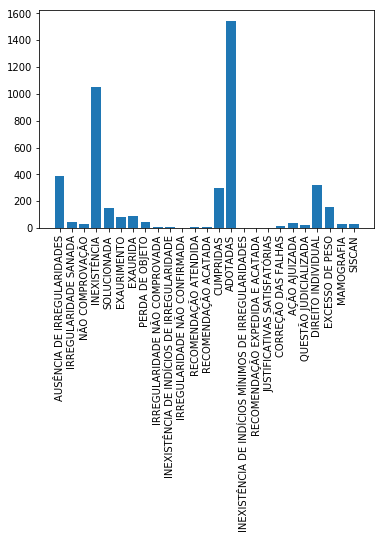

In [21]:
plot_keywords(p_homologados)

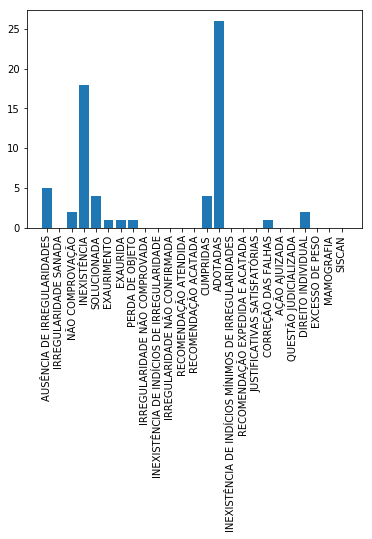

In [22]:
plot_keywords(p_nao_homologados)

Algumas palavras aparecem e uma quantidade significativa nas 2 classes. Exemplos: ADOTADAS e INEXISTENCIA. Talvez valha a pena treinar um modelo sem elas.

# Treinando um modelo com Random Forest

In [89]:
# vamos treinar o modelo
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4710, 29), (1571, 29))

In [90]:
cols_to_remove = ['id', 'peca_promocao', 'homologado']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [91]:
model.score(train[features], train['homologado'])

0.9828025477707006

In [92]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

    
print_score()

Accuracy score: 0.9910884786760026
Precision score:  0.9910884786760026
Recall score:  1.0
F1 score:  0.9955242966751918


In [93]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   14],
       [   0, 1557]], dtype=int64)

### Treinando sem as palavras chaves INEXISTÊNCIA e ADOTADAS

In [94]:
cols_to_remove = ['id', 'peca_promocao', 'homologado', 'INEXISTÊNCIA', 'ADOTADAS']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9910884786760026
Precision score:  0.9910884786760026
Recall score:  1.0
F1 score:  0.9955242966751918


In [95]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   14],
       [   0, 1557]], dtype=int64)

### Analisando a presença de palavras-chaves em conjunto

A ideia é analisar o efeito não apenas das palavras-chave em isolamento, mas também da presença combinada delas.

In [96]:
'''
IDEIA: criar uma variável que representa a soma dos valores das palavra-chaves.
Em suma, vai indicar o número de palavras-chaves presentes no texto.
'''
#df_work['palavras_combinadas'] = 0
for row in range(len(df_work)):
    present = 0
    for k in range(len(palavras_chaves)):
        if palavras_chaves['palavras-chaves'][k].rfind('+') == -1:
            column = str(palavras_chaves['palavras-chaves'][k])
            if df_work.loc[row, column] == 1:
                present += 1
    df_work.loc[row, 'palavras_combinadas'] = present

df_work.sample(10)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN,palavras_combinadas
5354,1,64423873,EXCELENTÍSSIMO Autos nº 1.33.001.000321/2015-...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1715,1,81658440,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA V...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
411,1,80184491,IC nº 1.29.018.000710/2017-23 Promoçã...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4225,1,75709883,ModeloSilvio MINISTÉRIO PÚBLICO FEDERAL PROC...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2708,1,74596049,Ref.: PP Nº 1.17.001.000292/2016-93 Etiqueta P...,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2
2652,1,82988711,PROMOÇÃO DE ARQUIVAMENTO Trata-se de proced...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1063,1,81971247,IC nº 1.23.000.002961/2017-55 DESPACHO DE...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
97,1,87122128,Ref.: Procedimento Preparatório nº 1.15.000.00...,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2546,1,65533770,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4847,1,72260523,Tutela coletiva – procedimento preparatório Au...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [97]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4710, 29), (1571, 29))

In [98]:
cols_to_remove = ['id', 'peca_promocao', 'homologado']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [99]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9910884786760026
Precision score:  0.9910884786760026
Recall score:  1.0
F1 score:  0.9955242966751918


In [100]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   14],
       [   0, 1557]], dtype=int64)

### Feature Importance

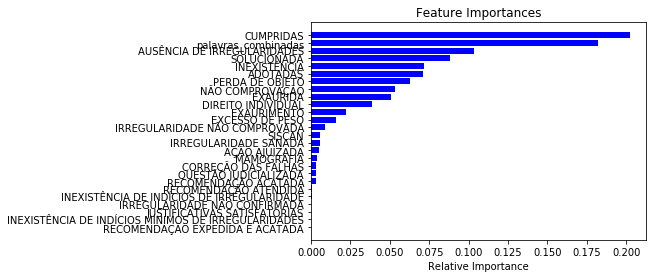

In [101]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

Vou retirar as *features* com importância menor que 5%.

In [102]:
important_features = []
indices = np.argsort(model.feature_importances_)
model.feature_importances_, indices

size = len(model.feature_importances_)
important_features = [features[i] for i in indices if i < size and model.feature_importances_[i] >= 0.05]

In [103]:
model = RandomForestClassifier(random_state=42, n_estimators=100)


model.fit(train[important_features], train['homologado'])
train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9910884786760026
Precision score:  0.9910884786760026
Recall score:  1.0
F1 score:  0.9955242966751918


In [104]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   14],
       [   0, 1557]], dtype=int64)

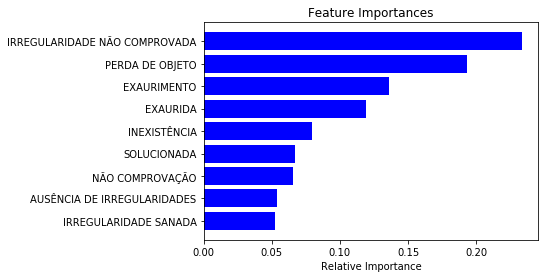

In [105]:
plot_fi(model.feature_importances_)

### Conclusão

O modelo com palavras-chaves não se mostrou muito bom. As palavras-chaves são bons indicadores, mas não são suficientes, por si só, para o treino de um modelo.

## Combinando as palavras-chaves com os outros metadados